In [158]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ngoctan/Gia SMP va SMPcap 2021(Gi th trng SMP) (1).csv


In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from sklearn.model_selection import StratifiedKFold
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [160]:
data = pd.read_csv('/kaggle/input/ngoctan/Gia SMP va SMPcap 2021(Gi th trng SMP) (1).csv',encoding='ISO-8859-1',delimiter=';')

In [180]:
feats = ['10', '11']

In [181]:
df[feats].head()

,10,11
0,964.4,964.4
1,1019.7,1019.7
2,988.4,988.4
3,1002.1,1010.8
4,1061.5,1061.5


## EDA

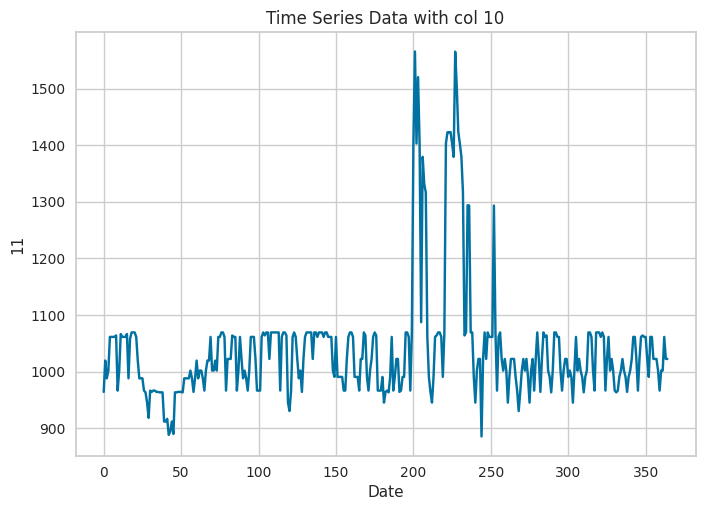

In [161]:
data.set_index('Ngày')
plt.plot(data.index,data['10'])
plt.title('Time Series Data with col 10')
plt.xlabel('Date')
plt.ylabel('11')
plt.show()


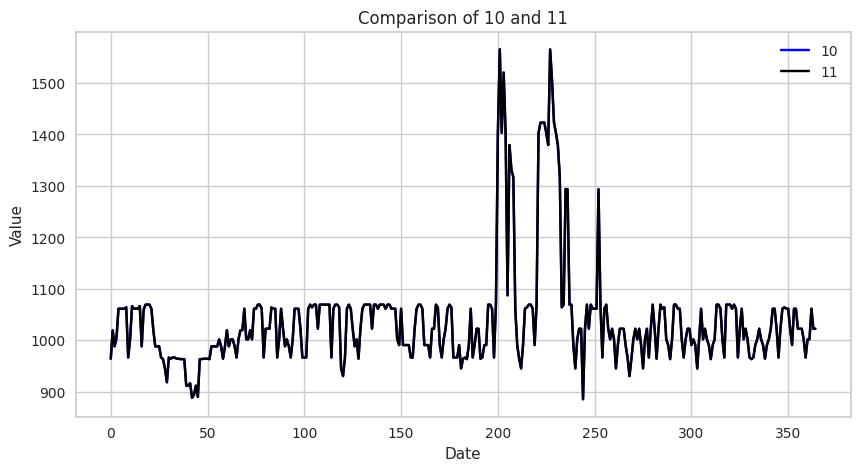

In [162]:
plt.figure(figsize=(10,5))
plt.plot(data['10'],color = 'blue',label = '10')
plt.plot(data['11'],color = 'black',label = '11')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of 10 and 11')
plt.legend()
plt.show()

## gaussion

In [163]:
feats = ['10', '11']
transformer = PowerTransformer()
X=transformer.fit_transform(data[feats])

In [164]:
pca = PCA(n_components=2,random_state=1)
pca.fit(X)
PCA_ds = pd.DataFrame(pca.transform(data[feats]), columns=(["col1","col2"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,365.0,-1470.838341,148.668195,-2213.409949,-1500.820607,-1445.821152,-1397.466876,-1252.262658
col2,365.0,32.556917,3.302432,27.698630,30.910383,31.979925,33.274633,48.958119


In [165]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)

#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= preds

In [166]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [167]:
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model)

[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[400]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[400]	valid_0's multi_logloss: 6.66134e-15


In [168]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [169]:
labels=np.argmax(lgb_preds,axis=1)

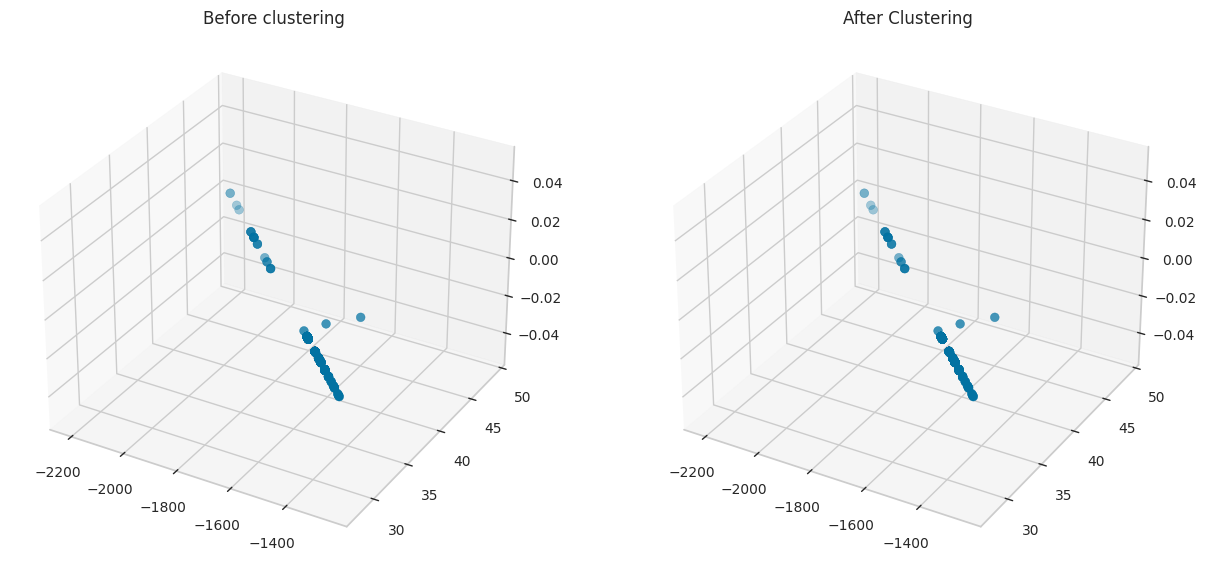

In [170]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, projection='3d', label="bla")
ax.scatter(PCA_ds['col1'],PCA_ds['col2'],s=40, marker='o', cmap = 'rainbow' )
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, projection='3d', label="bla")
ax.scatter(PCA_ds['col1'],PCA_ds['col2'], s=40, marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()


## arima

In [171]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [172]:
labels=np.argmax(lgb_preds,axis=1)

In [173]:
print('ADF Statistic : %f' %adfuller(data['10'])[0])
print('p-values: %f'%adfuller(data['10'])[1])

ADF Statistic : -2.786398
p-values: 0.060243


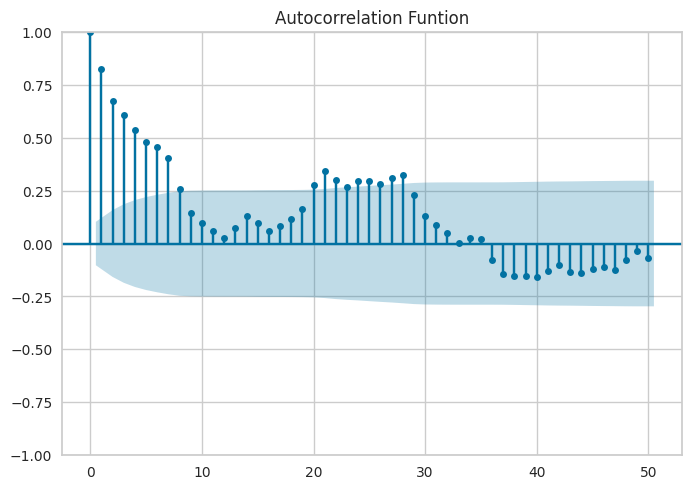

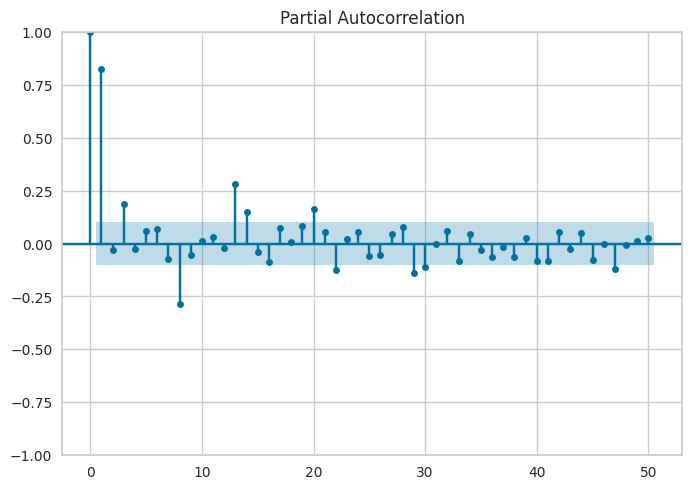

In [174]:
plot_acf(data['11'],lags =50)
plt.title('Autocorrelation Funtion')
plt.show()

plot_pacf(data['11'],lags =50)
plt.title('Partial Autocorrelation')
plt.show()

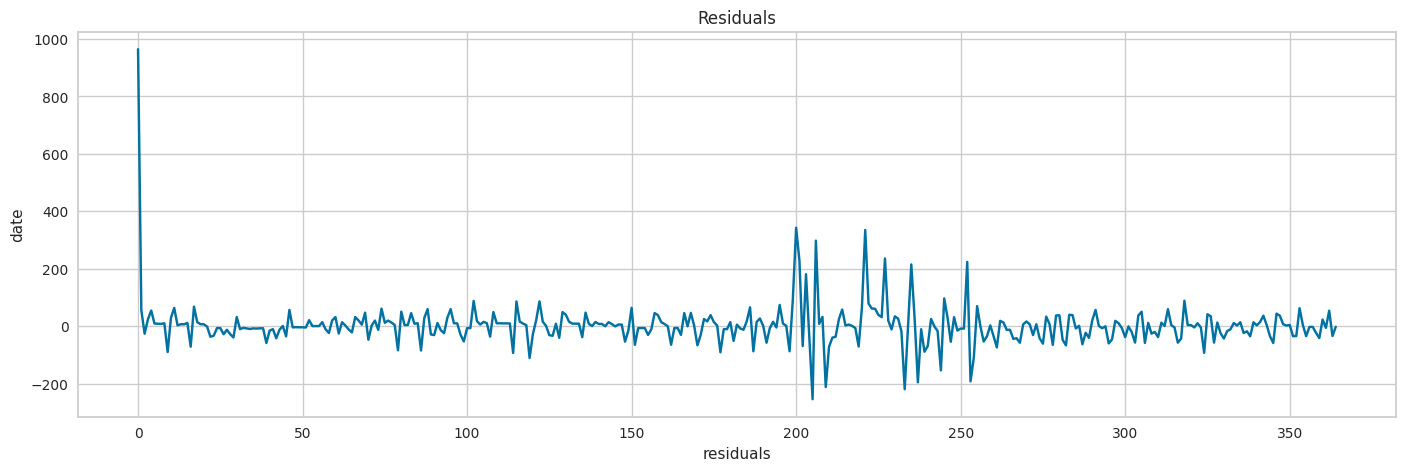

In [175]:
model = ARIMA(data['11'],order =(1,1,1))
model = model.fit()

plt.figure(figsize = (17,5))
residuals = model.resid
plt.plot(residuals)
plt.xlabel('residuals')
plt.ylabel('date')
plt.title('Residuals')
plt.show()

In [176]:
print('ADF Statistic : %f' %adfuller(residuals)[0])
print('p-values: %f'%adfuller(residuals)[1])

ADF Statistic : -5.251092
p-values: 0.000007


ADF Statistic: -9.345258
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


<Figure size 800x1000 with 0 Axes>

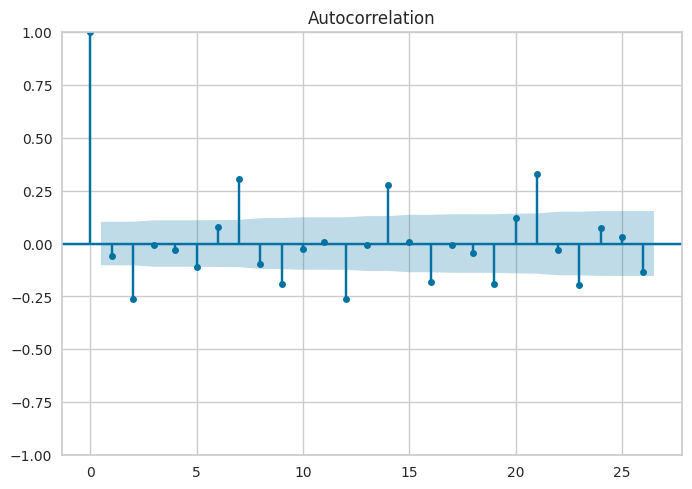

In [177]:
col_index = 10
r_t = np.log(df.iloc[:, col_index] / df.iloc[:, col_index].shift(1)).values

mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:10]

result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
plt.figure(figsize = (8, 10))
ax1 = plot_acf(r_t)

<Figure size 800x1000 with 0 Axes>

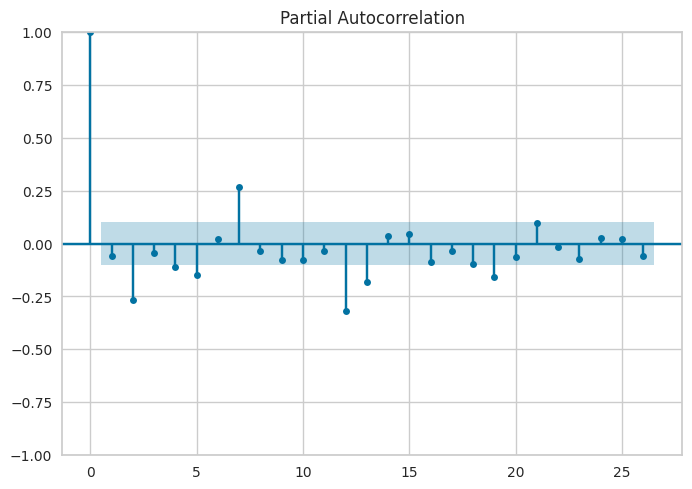

In [178]:
plt.figure(figsize = (8, 10))
ax2 = plot_pacf(r_t)

In [179]:
model_arima = ARIMA(r_t, order=(2, 0, 2))
model_fit = model_arima.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 564.416
Date:                Tue, 14 May 2024   AIC                          -1116.832
Time:                        04:56:46   BIC                          -1093.432
Sample:                             0   HQIC                         -1107.533
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.792e-05      0.001      0.066      0.948      -0.001       0.001
ar.L1         -0.0240      0.063     -0.382      0.702      -0.147       0.099
ar.L2          0.5960      0.056     10.574      0.0